In [13]:
import gc  
import os  
import time  
import warnings 
from itertools import combinations  
from warnings import simplefilter 
import joblib  
import playground.optivarfuncs as of
import lightgbm as lgb  
import numpy as np  
import pandas as pd  
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import KFold, TimeSeriesSplit  
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
is_offline = False 
is_train = True  
is_infer = True 
max_lookback = np.nan 
split_day = 435  
import polars as pl

# Functions

## Settings and helper Functions
There are 480 dates, 5 days a week or 96 weeks

In [14]:
class CONFIG:    
    #take last 3 months worth? or roughly 12*5=60.  So we want from (480-60) to 480
    # start_date=420

    #take last 1 months worth? or roughly 4*5=20.  So we want from (480-20) to 480
    start_date=460
    doHyperParamOptimization=False  #if true, #need train test and validation sets
    doTrainModel= True #if true, #need train and test sets
    runOnKaggle=True #if true, then concat all datasets before calculating features for Kaggle data

    use_subset_of_data=False

In [15]:
from gc import collect;
collect()

8

In [16]:
# Tracking kernel memory usage:-  
from os import path, walk, getpid;
from psutil import Process;
def GetMemUsage():
    """
    This function defines the memory usage across the kernel. 
    Source-
    https://stackoverflow.com/questions/61366458/how-to-find-memory-usage-of-kaggle-notebook
    """;
    
    pid = getpid();
    py = Process(pid);
    memory_use = py.memory_info()[0] / 2. ** 30;
    return f"RAM usage = {memory_use :.4} GB";

def cleanup(df):
    try:
        del df
        df=None
    except:
        pass
    collect()
    return GetMemUsage()

GetMemUsage()

'RAM usage = 2.504 GB'

In [17]:
#logging
import logging
# set up logging to file - see previous section for more details
logging.basicConfig(level=logging.INFO,
                    filename='logg.log',
                    filemode='w')
# define a Handler which writes INFO messages or higher to the sys.stderr
console = logging.StreamHandler()
# add the handler to the root logger
logging.getLogger().addHandler(console)
logger=logging.getLogger()

#use following to enable and disable
# logger.disabled = True

def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
               
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")
    return df


## Parallel Triplet Imbalance Calculation function

In [18]:
from numba import njit, prange

@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

def calculate_triplet_imbalance_numba(price, df):
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]
    features_array = compute_triplet_imbalance(df_values, comb_indices)
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)
    return features


## Feature Generation Functions 

In [19]:
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [20]:
def imbalance_features(df):
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")

    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
    
    df["stock_weights"] = df["stock_id"].map(weights)
    df["weighted_wap"] = df["stock_weights"] * df["wap"]
    df['wap_momentum'] = df.groupby('stock_id')['weighted_wap'].pct_change(periods=6)
   
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    
    df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
    df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    
    df['micro_price'] = ((df['bid_price'] * df['ask_size']) + (df['ask_price'] * df['bid_size'])) / (df['bid_size'] + df['ask_size'])
    df['relative_spread'] = (df['ask_price'] - df['bid_price']) / df['wap']
    
    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
        

    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1,3,5,10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)
    
    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'weighted_wap','price_spread']:
        for window in [1,3,5,10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)
    
    #V4 feature
    for window in [3,5,10]:
        df[f'price_change_diff_{window}'] = df[f'bid_price_diff_{window}'] - df[f'ask_price_diff_{window}']
        df[f'size_change_diff_{window}'] = df[f'bid_size_diff_{window}'] - df[f'ask_size_diff_{window}']

    #V5 - rolling diff
    # Convert from pandas to Polars
    pl_df = pl.from_pandas(df)

    #Define the windows and columns for which you want to calculate the rolling statistics
    windows = [3, 5, 10]
    columns = ['ask_price', 'bid_price', 'ask_size', 'bid_size']

    # prepare the operations for each column and window
    group = ["stock_id"]
    expressions = []

    # Loop over each window and column to create the rolling mean and std expressions
    for window in windows:
        for col in columns:
            rolling_mean_expr = (
                pl.col(f"{col}_diff_{window}")
                .rolling_mean(window)
                .over(group)
                .alias(f'rolling_diff_{col}_{window}')
            )

            rolling_std_expr = (
                pl.col(f"{col}_diff_{window}")
                .rolling_std(window)
                .over(group)
                .alias(f'rolling_std_diff_{col}_{window}')
            )

            expressions.append(rolling_mean_expr)
            expressions.append(rolling_std_expr)

    # Run the operations using Polars' lazy API
    lazy_df = pl_df.lazy().with_columns(expressions)

    # Execute the lazy expressions and overwrite the pl_df variable
    pl_df = lazy_df.collect()

    # Convert back to pandas if necessary
    df = pl_df.to_pandas()
    gc.collect()
    
    df['mid_price*volume'] = df['mid_price_movement'] * df['volume']
    df['harmonic_imbalance'] = df.eval('2 / ((1 / bid_size) + (1 / ask_size))')
    
    for col in df.columns:
        df[col] = df[col].replace([np.inf, -np.inf], 0)

    return df

def other_features(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60  
    df["minute"] = df["seconds_in_bucket"] // 60  
    df['time_to_market_close'] = 540 - df['seconds_in_bucket']
    
    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

def generate_all_features(df):
    #infer near and far prices
    bs=of.bfs(['near_price','far_price'],df,None)
    df = df.progress_apply(bs.backfill, axis=1)
    
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    df = df[cols]
    
    # Generate imbalance features
    df = imbalance_features(df)
    gc.collect() 
    df = other_features(df)
    gc.collect()  
    feature_name = [i for i in df.columns if i not in ["row_id", "target", "time_id", "date_id"]]
    
    return df[feature_name]


# Data Loading and Preprocessing 

In [21]:
# df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")
df = pd.read_csv("./data/train.csv")

df = df.dropna(subset=["target"])  #drop all rows with NaN in target
df.reset_index(drop=True, inplace=True)
df_shape = df.shape
GetMemUsage()

In [22]:
if(CONFIG.use_subset_of_data):
    #just take the last 4 weeks
    df=df[df.date_id>CONFIG.start_date]
print(f'df shape={df.shape}')

df shape=(5237892, 17)


# Data Splitting

In [23]:
if ( doHyperParamOptimization == True):
    #need train validation and test sets
    df_train, df_valid, df_tst, y_train, y_valid, y_tst =of.get3_DatasetAndTarget(df, dep_var='target', val_size=0.1, test_size=0.1,verbose = False)
else if ( doTrainModel == True):
    #just need a train and a valid set
    df_train, df_valid, y_train, y_valid =of.get2_DatasetAndTarget(df, dep_var='target', val_size=0.1,verbose = False)    
GetMemUsage()

For days[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 24

In [92]:
cleanup(df)

'RAM usage = 16.15 GB'

# Calculate features

In [24]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]
weights = {int(k):v for k,v in enumerate(weights)}

In [ ]:
%%time
global_stock_id_feats = {
        "median_size": df_train.groupby("stock_id")["bid_size"].median() + df_train.groupby("stock_id")["ask_size"].median(),
        "std_size": df_train.groupby("stock_id")["bid_size"].std() + df_train.groupby("stock_id")["ask_size"].std(),
        "ptp_size": df_train.groupby("stock_id")["bid_size"].max() - df_train.groupby("stock_id")["bid_size"].min(),
        "median_price": df_train.groupby("stock_id")["bid_price"].median() + df_train.groupby("stock_id")["ask_price"].median(),
        "std_price": df_train.groupby("stock_id")["bid_price"].std() + df_train.groupby("stock_id")["ask_price"].std(),
        "ptp_price": df_train.groupby("stock_id")["bid_price"].max() - df_train.groupby("stock_id")["ask_price"].min(),
    }
df_train_feats = generate_all_features(df_train)
print("Build Train Feats Finished.")
df_valid_feats = generate_all_features(df_valid)
print("Build Valid Feats Finished.")

if(doHyperParamOptimization==True):
    df_tst_feats = generate_all_features(df_tst)
    print("Build tst Feats Finished.")

GetMemUsage()

# Reduce memory

In [26]:
df_train_feats = reduce_mem_usage(df_train_feats)
df_valid_feats = reduce_mem_usage(df_valid_feats)
if(doHyperParamOptimization==True):
    df_tst_feats = reduce_mem_usage(df_tst_feats)

'RAM usage = 8.269 GB'

# Save and Reload df

In [27]:
df_train_feats.to_parquet("./tof_train.parquet")
df_valid_feats.to_parquet("./tof_valid.parquet")
if(doHyperParamOptimization==True):
    df_tst_feats.to_parquet("./tof_tst.parquet")

In [28]:
df_train_feats=pd.read_parquet("./tof_train.parquet")
df_valid_feats=pd.read_parquet("./tof_valid.parquet")
if(doHyperParamOptimization==True):
    df_tst_feats=pd.read_parquet("./tof_tst.parquet")

# Hyperparameter Optimization

Evaluation via Cross Validation with TimeSeriesSplit¶

In [56]:
def evaluate_simple(model, X, y):   

    y_pred = model.predict(X)
    return mean_absolute_error(y_pred, y_tst)
import lightgbm as lgb
import sklearn.datasets
import sklearn.metrics
# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
# train_x=pd.concat([df_train_feats, df_val_feats])
# train_y=pd.concat([y_train, y_valid])
def objective(trial):

    param = {
        "objective": "mae",
        'n_estimators': 6000,
        'num_leaves' : trial.suggest_int('num_leaves', 200,300),
        "subsample": 0.6,
        "colsample_bytree": 0.8,
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,11,12]),
        "n_jobs": 4,
        "device": "gpu",
        "verbosity": -1,
        "objective": "mae",
        'random_state': 48,
        
        'reg_alpha': trial.suggest_loguniform('reg_alpha', .15, .25),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 2.5, 4),
        
        'max_depth': trial.suggest_categorical('max_depth', [10,11,12])
    }
    model = lgb.LGBMRegressor(**param)  
    
    model.fit(df_train_feats,y_train,eval_set=[(df_valid_feats,y_valid)], callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True),lgb.callback.log_evaluation(period=100)])

    y_pred = model.predict(df_tst_feats)
    score = mean_absolute_error(y_tst, y_pred)
    return score

In [ ]:
if doHyperParamOptimization==True:
    import optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)

In [58]:
study.best_trial.params

{'num_leaves': 244,
 'learning_rate': 0.01,
 'max_depth': 11,
 'reg_alpha': 0.23746308577367767,
 'reg_lambda': 2.702844990315888}

## Last optuna run for lightgbm gave these params

lgb_params={'num_leaves': 244,
 'learning_rate': 0.01,
 'max_depth': 11,
 'reg_alpha': 0.23746308577367767,
 'reg_lambda': 2.702844990315888}

# Eval

In [67]:
def get_mae(model, X_tst,y_tst):
    y_pred = model.predict(X_tst)
    return mean_absolute_error(y_pred, y_tst)

def evaluate_simple(model, X_train, X_val, X_tst, y_train, y_val, y_tst):   
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True),lgb.callback.log_evaluation(period=100)])
    return get_mae(model, X_tst,y_tst)

def average_target(av_target_train, X_train, X_val, X_tst, y_train, y_val, y_tst):   
    # model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(50, verbose=False)])
    return len(y_tst), mean_absolute_error([av_target_train]*len(y_tst), y_tst)

In [62]:
lgb_params={'num_leaves': 244,
 'learning_rate': 0.01,
 'max_depth': 11,
 'reg_alpha': 0.23746308577367767,
 'reg_lambda': 2.702844990315888}

## For a training run

In [63]:
%%time
# Train a LightGBM model for the current fold
model = lgb.LGBMRegressor(**lgb_params)
evaluate_simple(model, df_train_feats,df_valid_feats,df_tst_feats, y_train, y_valid, y_tst)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.664773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36500
[LightGBM] [Info] Number of data points in the train set: 4170948, number of used features: 162
[LightGBM] [Info] Start training from score -0.046345
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 81.3298
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 81.3298
CPU times: user 9min 7s, sys: 612 ms, total: 9min 8s
Wall time: 2min 19s


(538999, 5.871110966259306)

In [68]:
get_mae(model, df_tst_feats,y_tst)

5.871110966259306

In [69]:
#how about with just the non-infered near and far prices?
df_tst_feats1=df_tst_feats.reset_index(drop=True)
y_tst1=y_tst.reset_index(drop=True)

get_mae(model, df_tst_feats1[df_tst_feats1.syn_near_price==0], y_tst1[df_tst_feats1.syn_near_price==0])

5.068109531819056

In [71]:
get_mae(model, df_tst_feats1[df_tst_feats1.syn_near_price==1], y_tst1[df_tst_feats1.syn_near_price==1])

6.54015592994254

# Fit the model using all the data

In [79]:
X=pd.concat([df_train_feats, df_valid_feats])
y=pd.concat([y_train, y_valid])

In [80]:
%%time
model1 = lgb.LGBMRegressor(**lgb_params)
# model1.fit(X, y, eval_set=[(df_tst_feats, y_tst)], callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True),lgb.callback.log_evaluation(period=100)])
model1.fit(X, y, callbacks=[lgb.callback.log_evaluation(period=100)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.836678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36501
[LightGBM] [Info] Number of data points in the train set: 4698893, number of used features: 162
[LightGBM] [Info] Start training from score -0.046357
CPU times: user 9min 52s, sys: 956 ms, total: 9min 53s
Wall time: 2min 31s


LGBMRegressor(learning_rate=0.01, max_depth=11, num_leaves=244,
              reg_alpha=0.23746308577367767, reg_lambda=2.702844990315888)

In [81]:
y_pred = model1.predict(df_tst_feats)
mean_absolute_error(y_pred, y_tst)

5.869359151138934

In [78]:
y_pred = model1.predict(df_tst_feats)
mean_absolute_error(y_pred, y_tst)

5.85003779003602

Columns with poor contribution Index(['imbalance_buy_sell_flag_ret_5', 'seconds', 'syn_near_price',
       'imbalance_buy_sell_flag_ret_10', 'imbalance_buy_sell_flag_ret_1',
       'price_spread_diff_1', 'minute', 'imbalance_buy_sell_flag_ret_3'],
      dtype='object')


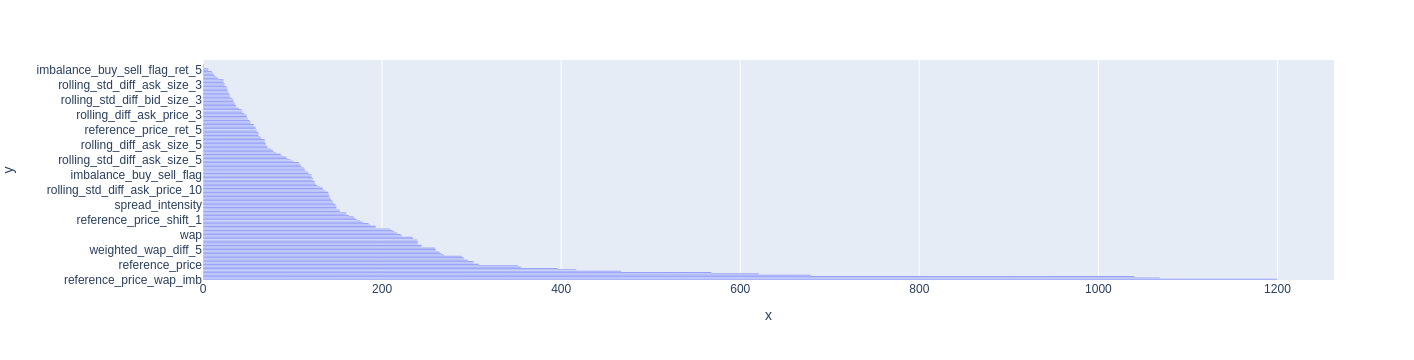

In [84]:
import plotly.express as px
feat_imp = pd.Series(model1.feature_importances_, index=X.columns).sort_values(ascending=False)
print('Columns with poor contribution', feat_imp[feat_imp<10].index)
fig = px.bar(x=feat_imp, y=feat_imp.index, orientation='h')
fig.show()

In [88]:
feat_imp

reference_price_wap_imb           1200
market_urgency                    1069
seconds_in_bucket                 1040
global_median_size                 679
reference_price_bid_price_imb      621
                                  ... 
imbalance_buy_sell_flag_ret_10       1
imbalance_buy_sell_flag_ret_1        1
price_spread_diff_1                  0
minute                               0
imbalance_buy_sell_flag_ret_3        0
Length: 162, dtype: int32

# Playground-Testing different portions of dataset -

In [20]:
lgb_params = {
        "objective": "mae",
        "n_estimators": 6000,
        "num_leaves": 256,
        "subsample": 0.6,
        "colsample_bytree": 0.8,
#         "learning_rate": 0.00871,
        "learning_rate": 0.01,
        'max_depth': 11,
        "n_jobs": 4,
        "device": "gpu",
        "verbosity": -1,
        "importance_type": "gain",
#         "reg_alpha": 0.1,
        "reg_alpha": 0.2,
        "reg_lambda": 3.25
    }


In [21]:
%%time
# Train a LightGBM model for the current fold
model = lgb.LGBMRegressor(**lgb_params)
evaluate_simple(model, df_train_feats,df_valid_feats,df_tst_feats, y_train, y_valid, y_tst)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 6.34673
[200]	valid_0's l1: 6.32678
[300]	valid_0's l1: 6.31741
[400]	valid_0's l1: 6.3097
[500]	valid_0's l1: 6.30577
[600]	valid_0's l1: 6.30235
[700]	valid_0's l1: 6.30018
[800]	valid_0's l1: 6.29888
[900]	valid_0's l1: 6.29798
[1000]	valid_0's l1: 6.29751
[1100]	valid_0's l1: 6.29708
[1200]	valid_0's l1: 6.29679
[1300]	valid_0's l1: 6.29636
[1400]	valid_0's l1: 6.2961
[1500]	valid_0's l1: 6.29593
[1600]	valid_0's l1: 6.29572
[1700]	valid_0's l1: 6.29572
Early stopping, best iteration is:
[1633]	valid_0's l1: 6.29569
CPU times: user 29min 53s, sys: 4.78 s, total: 29min 58s
Wall time: 7min 46s


(1066944, 5.928846513212814)

In [33]:
y_pred = model.predict(df_tst_feats)
mean_absolute_error(y_pred, y_tst)

5.930027978086307

In [55]:
#what about if we just test the ones not infered?
y_tst1=y_tst.reset_index(drop=True)
df_tst_feats1=df_tst_feats.reset_index(drop=True)
y_pred = model.predict(df_tst_feats1[df_tst_feats1.syn_near_price==0])
mean_absolute_error(y_pred, y_tst1[df_tst_feats1.syn_near_price==0])

5.153793577574254